In [85]:
import requests
import json
import base64
import tempfile

url = "https://api.runwayml.com/v1/inference/runway/AttnGAN/default/generate"

def fetch_generated_image(caption):
    payload = json.dumps({
      "inputData": {
        "caption": caption
      }
    })
    headers = {
      'Content-Type': 'application/json'
    }

    response = requests.request("POST", url, headers=headers, data=payload)

    base64txt = response.json()["result"]
    base64txt.split(",")[0]
    imgBytes = base64.b64decode(base64txt.split(",")[1])
    return imgBytes
    #with open("newestnew.jpeg", "wb") as f:
    #    f.write(imgBytes)


In [86]:
%%capture

import warnings
warnings.filterwarnings('ignore')

# External libraries
import pandas as pd
import nltk
from nltk.corpus import wordnet
import re
import string
import random
import numpy as np
import importlib

# My Files
import transition_matrix as tm
import caption

# Ensure files are latest version
importlib.reload(tm)
importlib.reload(caption)


# nltk downloads
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

In [176]:
from IPython.display import display
from PIL import Image

def closest_pixel(src, others, distance_selected = 2):
    closest = (-1, -1, -1)
    closest_euc_dist = float('inf')
    for pix in others:
        euc_dist = 0.0
        sum_of_new = 0.0
        sum_of_old = 0.0
        for i, channel in enumerate(pix):
            loc = {}
            if distance_selected == 1:
                euc_dist += float(abs(float(channel) - float(src[i]))**2)
            elif distance_selected == 2:
                sum_of_new += int(channel)
                sum_of_old += int(src[i])
            else:
                euc_dist += float(abs(float(channel) - float(src[i]))**2)
        if distance_selected == 2:
            euc_dist = abs(float(sum_of_new) - float(sum_of_old))
        if euc_dist < closest_euc_dist:
            closest_euc_dist = euc_dist
            closest = pix
    return closest, closest_euc_dist

def score_image_differences(img1, img2):
    #clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    #grayimg1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    #grayimg2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
    #cl1 = clahe.apply(grayimg1)
    #cl2 = clahe.apply(grayimg2)
    #display(Image.fromarray(cl1))
    #display(Image.fromarray(cl2))
    cl1 = img1
    cl2 = img2
    try:
        height, width, _ = cl1.shape
    except:
        height, width = cl1.shape

    scores = []
    src_imgs = [cl2]
    print("H {} W {}".format(height, width))
    print(img2.shape)
    print(img1.shape)
    for i in range(height - 1):
        for j in range(width - 1):
            pixels = []
            for k in range(len(src_imgs)):
                pixels.append(src_imgs[k][i][j])
            _, score = closest_pixel(cl1[i][j], pixels)
            scores.append(score)
    return scores

In [177]:
from IPython.display import display
from PIL import Image
import cv2 as cv
import numpy as np

def score_haiku(haiku, seed_words, original_img_file):
    
    words = [w for w in haiku.split(" ")]
    text = nltk.word_tokenize(" ".join(words))
    tagged_text = nltk.pos_tag(text)
    
    # https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk list of tag meanings
    acceptable = ['NN', 'JJ', 'JJR', 'JJS' , 'NNS', 'PRP', 'RB', 'RBR', 'RBS', 'VB', 'RP', 'VBD', 'VBG', 'VBN', 'VBP']
    print(tagged_text)
    acceptable_words = list(filter(lambda c: c[1]  in acceptable, tagged_text))
    print(acceptable_words)
    acceptable_words = {w for w, _ in acceptable_words}
    print(acceptable_words)
    imgBytes = fetch_generated_image(" ".join(acceptable_words))
    imgBytesSeed = fetch_generated_image(" ".join(seed_words))
    with tempfile.TemporaryFile() as fp, tempfile.TemporaryFile() as fp2:
        fp.write(imgBytes)
        fp.seek(0)
        fp2.write(imgBytesSeed)
        fp2.seek(0)
        sentences, scores = caption.get_caption(fp)
        display(Image.open(fp))
        display(Image.open(fp2))
        sentences_and_scores = sorted(zip(scores, sentences))[::-1]
        scores = [float(s) for s in scores]
        words = []
        for _, s in sentences_and_scores:
            print(s)
            for w in s:
                if w in ["<start>", "<end>"]:
                    continue
                words.append(w)
        text = nltk.word_tokenize(" ".join(words))
        tagged_text = nltk.pos_tag(text)

        #acceptable_words = [w if t in acceptable else None for w, t in tagged_text]
        acceptable_words = list(filter(lambda c: c[1]  in acceptable, tagged_text))
        acceptable_words = {w for w, _ in acceptable_words}
        print(acceptable_words)
        intersection_set = set.intersection(set(acceptable_words), set(seed_words))
        shared_words = list(intersection_set)
        print(shared_words)
        print(min(len(acceptable_words), len(seed_words)))
        final_score = len(shared_words) / min(len(acceptable_words), len(seed_words))
        
        res_img = np.array(Image.open(fp))
        original_img = cv.imread(original_img_file)
        seed_gen_img = np.array(Image.open(fp2))
        height, width, _ = original_img.shape
        res_img2 = cv.resize(res_img, (width, height))

        img_scores = score_image_differences(res_img, seed_gen_img)
        img_score = sum(img_scores) / len(img_scores)
        return final_score, img_score
        

[('woman', 'NN'), ('scrubs', 'VBZ'), ('the', 'DT'), ('smell', 'NN'), ('of', 'IN'), ('rain', 'NN'), ('noticed', 'VBN'), ('by', 'IN'), ('night', 'NN'), ('at', 'IN'), ('jung', 'NN'), ('yang', 'NN'), ('.', '.'), ('lineendhere', 'VB')]
[('woman', 'NN'), ('smell', 'NN'), ('rain', 'NN'), ('noticed', 'VBN'), ('night', 'NN'), ('jung', 'NN'), ('yang', 'NN'), ('lineendhere', 'VB')]
{'rain', 'yang', 'noticed', 'night', 'jung', 'lineendhere', 'smell', 'woman'}


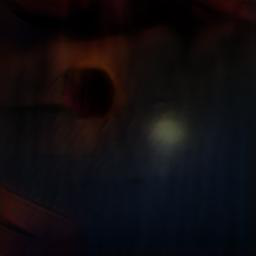

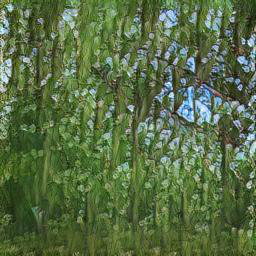

['<start>', 'a', 'blurry', 'image', 'of', 'a', 'person', 'in', 'a', 'dark', 'room', '<end>']
['<start>', 'a', 'blurry', 'image', 'of', 'a', 'blurry', 'image', 'of', 'a', 'blurry', 'background', '<end>']
['<start>', 'a', 'blurry', 'image', 'of', 'a', 'blurry', 'image', 'of', 'a', 'blurry', 'image', '<end>']
['<start>', 'a', 'blurry', 'image', 'of', 'a', 'blurry', 'image', 'of', 'a', 'blurry', 'image', 'of', 'a', 'blurry', 'background', '<end>']
['<start>', 'a', 'blurry', 'image', 'of', 'a', 'blurry', 'image', 'of', 'a', 'blurry', 'image', 'of', 'a', 'blurry', 'image', '<end>']
{'person', 'room', 'image', 'blurry', 'dark'}
[]
5
H 256 W 256
(256, 256, 3)
(256, 256, 3)


(0.0, 221.85228758169936)

In [185]:
img_file = "./images/woman.jpeg"
score_haiku("woman scrubs the smell of rain noticed by night at jung yang",
            ['field', 'forest', 'ground', 'park', 'sitting', 'tree', 'woman'],
           img_file)

In [184]:
x = {'rain', 'yang', 'noticed', 'night', 'jung', 'smell', 'woman'}
print(" ".join(x))

rain yang noticed night jung smell woman
